# Joining

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import copy

import os
import sys
sys.path.insert(0, "../../src")
from cut_predictor import DoubleProjectionPredictor
from banana_lib import UV2d, UVJoint

In [2]:
reg_xyz = DoubleProjectionPredictor.from_h5('../../models/joining_xyz.h5')

In [3]:
reg_thickness = DoubleProjectionPredictor.from_h5('../../models/joining_thickness.h5')

In [4]:
process_parameters={
    # Joining
    'Spanner_1': -3,
    'Spanner_2': -3,
    'Spanner_3': -5,
    'Spanner_4': 3,
    'Oberblech_MID': 5,
    'Unterblech_MID': 3,

    # Top
    'Blechdicke_top': 1.48, 
    'Niederhalterkraft_top': 400, 
    'Ziehspalt_top': 2.4, 
    'Einlegeposition_top': -4, 
    'Ziehtiefe_top': 50,
    'Rp0_top': 235.160326,

    # Bottom
    'Blechdicke_bot': 1.01, 
    'Niederhalterkraft_bot': 410, 
    'Ziehspalt_bot': 2.4, 
    'Einlegeposition_bot': -5, 
    'Ziehtiefe_bot': 30,
    'Rp0_bot': 138.226960,
}

## 3D prediction

### load uv grid in desired resolution

https://owncloud.fraunhofer.de/index.php/apps/files/?dir=/ML%40Karoprod/MachineLearning/uvgrids&fileid=524247175

In [5]:
elsize = 0.02

filepath = f"../../uvgrids/uv_{elsize}.h5"
uv = UV2d.from_h5(filepath)

initialize uv grids for joint parts

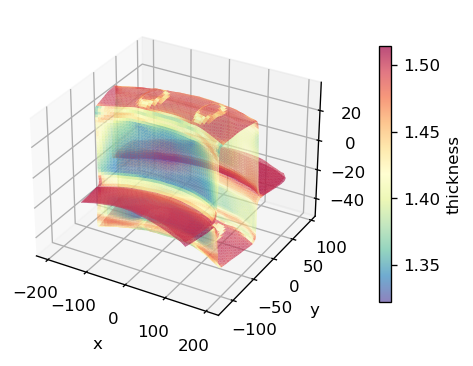

In [6]:
uvj = UVJoint(uv, reg_xyz=reg_xyz, reg_results=reg_thickness)
uvj.predict(process_parameters)
fig = uvj.plot_3d(result_name="thickness", figsize=(8,3))
fig.tight_layout()

inspect results for top sheet

In [7]:
uvj.uv_top.nodes.head(2)

,nid,u,v,x,y,z,thickness,epseqpl,thinning
1,1,0.00,0.0,-123.792900,-118.344429,-11.234180,1.498831,-0.000399,1.013653
2,2,0.02,0.0,-119.433647,-117.227539,-11.270329,1.499751,-0.000363,1.013942


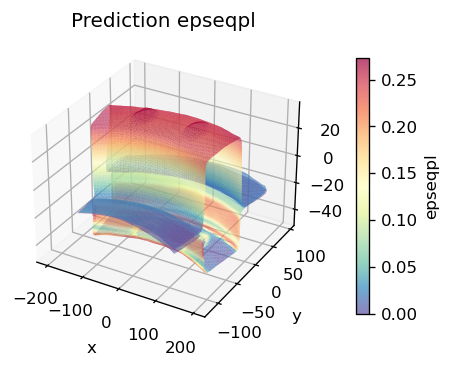

In [8]:
result_name = "epseqpl"
fig = plt.figure(1, figsize=(8,3))
ax = fig.add_subplot(111, projection="3d")
c_bot = ax.plot_trisurf(uvj.uv_bot.nodes.x, uvj.uv_bot.nodes.y, uvj.uv_bot.nodes.z, 
                triangles=uvj.uv_bot.elements.simplices.tolist(), cmap=plt.cm.Spectral_r, 
                alpha=.7, shade=False, linewidth=2)
c_top = ax.plot_trisurf(uvj.uv_top.nodes.x, uvj.uv_top.nodes.y, uvj.uv_top.nodes.z, 
                triangles=uvj.uv_top.elements.simplices.tolist(), cmap=plt.cm.Spectral_r, 
                alpha=.7, shade=False, linewidth=2)
c_bot.set_array(uvj.uv_bot.elements[result_name])
cbar = fig.colorbar(c_bot, fraction=.015, label=result_name, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title(f"Prediction {result_name}")
fig.tight_layout()

## simple prediction

In [ ]:
df_xyz = reg_xyz.predict(
    process_parameters,
    positions=(200, 200),
    as_df=True
)
df_thickness = reg_thickness.predict(
    process_parameters,
    positions=(200, 200),
    as_df=True
)

df = df_xyz.copy()
df['thickness'] = df_thickness['thickness']
df['epseqpl'] = df_thickness['epseqpl']
df['thinning'] = df_thickness['thinning']
df

In [ ]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()

def plotly_show_surface(df):
    y = df[['x', 'y', 'z']].to_numpy()
    N, _ = y.shape
    # Configure the trace.
    trace_top = go.Scatter3d(
        x=y[:int(N/2), 0],  
        y=y[:int(N/2), 1],
        z=y[:int(N/2), 2],
        mode='markers',
        marker={
            'size': 1.0,
            'opacity': 1.0,
        }
    )
    trace_bot = go.Scatter3d(
        x=y[int(N/2):, 0],  
        y=y[int(N/2):, 1],
        z=y[int(N/2):, 2],
        mode='markers',
        marker={
            'size': 1.0,
            'opacity': 1.0,
        }
    )
    layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
    plot_figure = go.Figure(data=[trace_top, trace_bot], layout=layout)
    plotly.offline.iplot(plot_figure)

def plotly_show_features(df, feature):
    y = df[['x', 'y', 'z', feature]].to_numpy()
    N, _ = y.shape
    # Configure the trace.
    trace_top = go.Scatter3d(
        x=y[:int(N/2), 0],  
        y=y[:int(N/2), 1],
        z=y[:int(N/2), 2],
        mode='markers',
        marker={
            'size': 1.0,
            'opacity': 1.0,
            'color': y[:int(N/2), 3],
        }
    )
    trace_bot = go.Scatter3d(
        x=y[int(N/2):, 0],  
        y=y[int(N/2):, 1],
        z=y[int(N/2):, 2],
        mode='markers',
        marker={
            'size': 1.0,
            'opacity': 1.0,
            'color': y[int(N/2):, 3],
        }
    )
    layout = go.Layout(margin={'l': 0, 'r': 0, 'b': 0, 't': 0})
    plot_figure = go.Figure(data=[trace_top, trace_bot], layout=layout)
    plotly.offline.iplot(plot_figure)

%matplotlib inline
plt.rcParams['figure.dpi'] = 150

def mpl_show_surface(df):

    y = df[['x', 'y', 'z']].to_numpy()
    N, _ = y.shape

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(
        y[:int(N/2), 0],  
        y[:int(N/2), 1],
        y[:int(N/2), 2],
        s=0.001
    )
    p = ax.scatter(
        y[int(N/2):, 0],  
        y[int(N/2):, 1],
        y[int(N/2):, 2],
        s=0.005
    )
    plt.show()

In [ ]:
plotly_show_surface(df_xyz)

In [ ]:
plotly_show_features(df, 'thickness')

In [ ]:
plotly_show_features(df, 'epseqpl')

In [ ]:
plotly_show_features(df, 'thinning')

## x0 cut

In [ ]:
x0_cut = pd.DataFrame({"u": .5, "v": np.linspace(0., 1. , 100)}).to_numpy()

df_xyz = reg_xyz.predict(
    process_parameters,
    positions=x0_cut,
    as_df=True
)
df_thickness = reg_thickness.predict(
    process_parameters,
    positions=x0_cut,
    as_df=True
)

df = df_xyz.copy()
df['thickness'] = df_thickness['thickness']
df['epseqpl'] = df_thickness['epseqpl']
df['thinning'] = df_thickness['thinning']
df

In [ ]:
def plot_cut(df):
    
    y = df[['x', 'y', 'z', 'thickness']].to_numpy()
    N, _ = y.shape

    plt.figure()
    plt.plot(y[:int(N/2), 1], y[:int(N/2), 2] - y[:int(N/2), 3]/2)
    plt.plot(y[int(N/2):, 1], y[int(N/2):, 2] + y[int(N/2):, 3]/2)
    plt.xlabel("y")
    plt.ylabel("z")
    plt.title("x0 cut")

    gap = (y[:int(N/2), 2] - y[:int(N/2), 3]/2) - (y[int(N/2):, 2] + y[int(N/2):, 3]/2)
    print(gap.min(), gap.max())

    plt.figure()
    plt.plot(gap)
    plt.xlabel("y")
    plt.ylabel("gap")
    plt.title("x0 cut")

plot_cut(df)

In [ ]:
cut = pd.DataFrame({"u": np.linspace(0., 1. , 100), "v": 0.061205}).to_numpy()
cut = pd.DataFrame({"u": np.linspace(0., 1. , 100), "v": 0.936}).to_numpy()

df_xyz = reg_xyz.predict(
    process_parameters,
    positions=cut,
    as_df=True
)
df_thickness = reg_thickness.predict(
    process_parameters,
    positions=cut,
    as_df=True
)

df = df_xyz.copy()
df['thickness'] = df_thickness['thickness']
df['epseqpl'] = df_thickness['epseqpl']
df['thinning'] = df_thickness['thinning']
df

In [ ]:
top = df[df['part']==1]
bot = df[df['part']==0]

plt.plot(top['x'], top['z'] - top['thickness']/2.)
plt.plot(top['x'], bot['z'] + bot['thickness']/2.)